In [110]:
from functions.FullBending import FullBending
import pandas as pd

In [111]:
# E [GPa]
# nucleo	4.22
# X	26.95
# SX	13.57
# Y	97.86
# SY	4.22

df_layers = pd.DataFrame({ 'E': [0.800000,
                                 5.198613, 
                                 2.814443, 
                                 21.284290, 
                                 5.775806]}, index=['nucleo', 'X', 'SX', 'Y', 'SY'])

In [112]:
df_layers

,E
nucleo,0.800000
X,5.198613
SX,2.814443
Y,21.284290
SY,5.775806


In [113]:
from validation.BendingExperimental import BendingExperimental

r = BendingExperimental()

df_stats = r["df_stats"]

# layers = df_stats["layers"]
# layers[0] = ["Y","Y"]
# df_stats["layers"] = layers

In [114]:
df_stats

Eb [GPa]              t [mm]               b [mm]            \
           mean       std      mean       std       mean       std   
Name                                                                 
TFP1  13.201050  0.630858  5.266667  0.057735  25.600000  0.100000   
TFP2   9.869501  0.780113  4.700000  0.000000  25.566667  0.057735   
TFP3   9.222003  0.495965  4.833333  0.057735  25.400000  0.173205   
TFP4  10.181815  0.770635  4.700000  0.000000  25.666667  0.152753   
TFP5   6.143105  0.161637  5.700000  0.000000  25.166667  0.152753   
TFP6   7.798060  0.334186  5.600000  0.000000  25.033333  0.635085   

        Sb [MPa]                  layers v [X,SX,Y,SY] ni  
            mean        std                                
Name                                                       
TFP1  134.996667  18.942693          [Y]  [0, 0, 1, 0]  1  
TFP2  117.430000  15.759607       [Y, X]  [1, 0, 1, 0]  2  
TFP3  128.053333   5.337905      [Y, SX]  [0, 1, 1, 0]  2  
TFP4  141.703333   7.525386      [Y, SY]  [0, 0, 1, 1]  2  
TFP5  107.433333   3.902939  [Y, SX, SY]  [0, 1, 1, 1]  3  
TFP6  114.306667  11.800790   [Y, X, SY]  [1, 0, 1, 1]  3

In [115]:

import os 
from copy import deepcopy
join = os.path.join

E_pred = []

if not os.path.exists("output"):
    os.mkdir("output")

params = {
            "geo" : {
                        "t_n" : 3.073400,
                        "t_l" : 2*0.427120,
                        "Lx"  : 30,
                        "meshsizefactor" : 1.1
                    },
            "sim" : {
                        "disp" : 5.0,
                        "opt": {
                                "OMP_NUM_THREADS":4,
                                "mpi_np":4,
                                "mpi":True
                                },
                    },
        }


all_params = []

id_design = 0
E_n =   df_layers.loc["nucleo"].values[-1]*1e3

lyrs = df_stats["layers"].iloc[id_design]

print("\n\nLayers: ", lyrs, "\n\n")
E_l = df_layers.loc[lyrs]["E"].values*1e3 # MPa
name_mat = df_stats["layers"].iloc[id_design]
name = df_stats.index[id_design]
B    = df_stats["b [mm]"]["mean"].iloc[id_design]

params_loop = deepcopy(params)

B = 25
params_loop["geo"]["Ly"] = B
params_loop["sim"]["E_n"] = E_n
params_loop["sim"]["E_l"] = E_l
params_loop["sim"]["name_mat"] = name_mat
params_loop["output_folder"] = join("output")

print(params)
inp_f = FullBending(params_loop)
Eflex_FEM = params_loop["Eflex"]




Layers:  ['Y'] 


{'geo': {'t_n': 3.0734, 't_l': 0.85424, 'Lx': 30, 'meshsizefactor': 1.1}, 'sim': {'disp': 5.0, 'opt': {'OMP_NUM_THREADS': 4, 'mpi_np': 4, 'mpi': True}}}
Running Calculix at:  output\sim
Output file:  c:\Users\djoroya\Documents\GitHub\CITISENS_Composite_v2\scripts\T02_Modelo_MultiCapa\T01_NumericalBasic\output\sim\out.txt
Command:
 C:\Program Files\Microsoft MPI\Bin\mpiexec -n 4 c:\Users\djoroya\Documents\GitHub\CITISENS_Composite_v2\.conda\Lib\site-packages\djccx\bin\ccx_dynamic.exe main
Error reading cvf file

pid:  12420 

Calculix finished



In [116]:
def E_flex_inercia(E_n,E_l,t_n,t_l,B):

    t_t = t_n + 2*t_l
    # print(t_t)

    yG = t_n*0.5 + t_l*0.5

    I_tot = (1/12)*B*t_t**3
    I_l   = (1/12)*B*t_l**3 + B*t_l*yG**2
    I_n   = (1/12)*B*t_n**3 


    Eflex = (E_n*I_n + 2*E_l*I_l)/(I_tot)

    return Eflex*1e-3 # GPa

In [117]:
t_n = params_loop["geo"]["t_n"]
t_l = params_loop["geo"]["t_l"]

In [118]:
print("E_n", E_n)
print("E_l", E_l[0])
print("tn",t_n)
print("tl",t_l)
print("B",B)

E_n 800.0
E_l 21284.289999999997
tn 3.0734
tl 0.85424
B 25


In [119]:
Eflex_pred_inercia = E_flex_inercia(E_n,E_l[0],t_n,t_l,B)

In [120]:
def E_tracion_an(E_n,E_l,t_n,t_l):

    t_t = t_n + 2*t_l

    Etrac = (E_n*t_n + 2*E_l*t_l)/(t_t)

    return Etrac*1e-3 # GPa

In [121]:
from AnalyticalLayers.models import E_flexion  as E_flexion_fcn

In [122]:
t_n = params_loop["geo"]["t_n"]
t_l = params_loop["geo"]["t_l"]

Eflex_pred = E_flex_inercia(E_n,
                          E_l[0],
                          t_n,
                          t_l,B)

Eflex_pred_fcn = E_flexion_fcn(E_n,
                           [0,0,E_l[0],0],
                           t_n,
                           t_l,layers=lyrs)
Eflex_pred_fcn = Eflex_pred_fcn*1e-3

In [123]:
Eflex_pred - params_loop["Eflex"]

print("Analitico: ", Eflex_pred)
print("Simulado: ", Eflex_FEM)
print("Analitico fcn: ", Eflex_pred_fcn)    


Analitico:  15.845752140285697
Simulado:  12.136144746821191
Analitico fcn:  15.845752140285692


In [124]:
print("Error (%) : ", abs(Eflex_pred - Eflex_FEM)/Eflex_FEM*100)

Error (%) :  30.56660472376254


In [126]:
x0 = 0
y0 = B/2
eps = 0.1
ifrd = inp_f.frd
ifrd = ifrd.copy()

ifrd = ifrd[ (ifrd["x"] > x0 - eps) & (ifrd["x"] < x0 + eps) ]
ifrd = ifrd[ (ifrd["y"] > y0 - eps) & (ifrd["y"] < y0 + eps) ]
ifrd

,x,y,z,D1,D2,D3,SXX,SYY,SZZ,SXY,...,EYZ,EZX,F1,F2,F3,STR(%),S_von_mises,P1,P2,P3
nid,,,,,,,,,,,,,,,,,,,,,
87,0.0,12.500000,-1.536700,0.0,0.080191,-4.91863,141.1940,-8.61114,-6.789410,0.001340,...,5.909790e-05,-1.504610e-06,-2.220540,-3.497720e-12,1.173450e-10,4.79477,148.902685,141.194001,-6.786652,-8.613899
167,0.0,12.500000,1.536700,0.0,0.080474,-4.99482,66.8128,53.84730,-42.807600,-0.136023,...,1.350990e-04,-9.849640e-05,-0.456047,-4.249300e-12,4.190830e-11,16.61460,103.758902,66.820661,53.846856,-42.815017
206,0.0,12.500000,-2.390940,0.0,0.080230,-4.91144,787.7340,129.94700,0.020464,-0.012553,...,5.091580e-07,-3.971200e-06,-5.324260,3.392410e-11,-7.637820e-11,2.32509,731.456521,787.734006,129.947000,0.020458
293,0.0,12.500000,2.390940,0.0,0.080294,-5.00000,-1804.0400,-843.92600,-1333.240000,-14.681400,...,4.157180e-04,3.737830e-02,12.212100,-6.566520e-12,-9.173250e+00,12.78410,1347.511295,-843.636376,-913.054574,-2224.515050
1387,0.0,12.489658,-2.190312,0.0,0.080270,-4.91382,665.1490,95.73970,-0.390082,-0.019584,...,4.771470e-06,-5.010510e-07,-0.045445,-1.682060e-10,-5.514810e-11,5.09073,623.061070,665.149001,95.739763,-0.390146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2767,0.0,12.554376,2.090789,0.0,0.080579,-4.99581,-680.1150,-174.49500,-315.275000,-4.877620,...,7.037620e-04,3.144520e-03,10.818800,1.302560e-11,1.799200e-10,14.03510,461.205804,-173.557188,-309.006765,-687.321047
2769,0.0,12.503409,1.994489,0.0,0.080327,-4.99569,-513.0830,-102.23300,-182.914000,-2.773730,...,5.524330e-04,1.080390e-03,8.154370,-4.391200e-11,-1.296380e-10,13.70970,378.637743,-101.229866,-182.946462,-514.053672
2770,0.0,12.449033,2.113958,0.0,0.079954,-4.99601,-722.1250,-210.75400,-358.089000,-0.026715,...,5.720510e-05,4.173260e-03,9.140300,-4.011900e-12,-2.046520e-10,13.15690,471.034334,-210.747700,-345.693312,-734.526988


In [127]:
#sort by z
ifrd = ifrd.sort_values("z")

In [128]:
from matplotlib import pyplot as plt

(-200.0, 850.0)

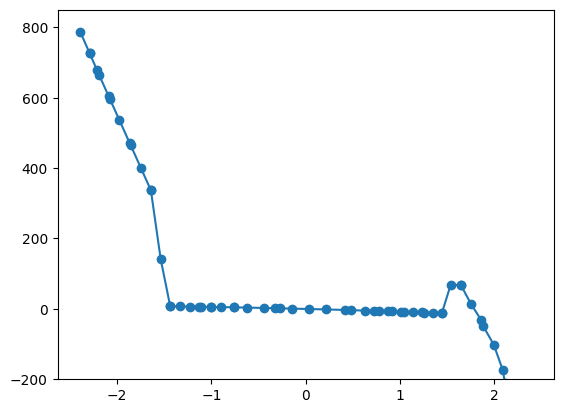

In [129]:
# plot 
plt.plot(ifrd["z"], ifrd["P1"], label="P1",marker="o")
plt.ylim([-200,850])

In [130]:
ifrd["P1"].values[0]

np.float64(787.734005606278)

In [131]:
E_eff = E_tracion_an(E_n,E_l[0],t_n,t_l)

In [132]:
E_eff

np.float64(8.118669598400627)

In [133]:
ifrd["x"]

nid
206     0.0
1488    0.0
1489    0.0
1493    0.0
1387    0.0
       ... 
2650    0.0
2754    0.0
2753    0.0
2752    0.0
293     0.0
Name: x, Length: 61, dtype: float64

In [134]:
ifrd = inp_f.frd
ifrd = ifrd.copy()
# sort 
ifrd = ifrd.sort_values("z")
P = -ifrd["F3"][ifrd["x"] < ifrd["x"].mean()].values
# P = ifrd["F3"].values
P = 2*P.sum()


L = 2*params["geo"]["Lx"]
tl = params["geo"]["t_l"]
tn = params["geo"]["t_n"]
D = 2*tl + tn

In [135]:
B

25

In [136]:
D

4.78188

In [137]:
P

np.float64(3071.8006009930928)

In [138]:
sigma_max = (3/2)*P*L/(B*D**2)
sigma_max

np.float64(483.6132320160776)

In [139]:
# plot 

ifrd = ifrd[ (ifrd["x"] > x0 - eps) & (ifrd["x"] < x0 + eps) ]
ifrd = ifrd[ (ifrd["y"] > y0 - eps) & (ifrd["y"] < y0 + eps) ]


In [140]:
E_l

array([21284.29])

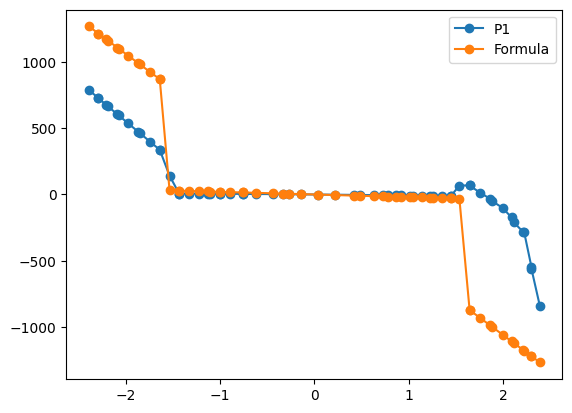

In [141]:

plt.plot(ifrd["z"], ifrd["P1"], label="P1",marker="o")
z = ifrd["z"]
zmax = D/2
sigma_i_an = -sigma_max*(E_l[0]/E_eff*(z/zmax) )*(z<-t_n/2) + \
             -sigma_max*(E_n/E_eff   *(z/zmax) )*(z>=-t_n/2)*(z<=t_n/2) + \
             -sigma_max*(E_l[0]/E_eff*(z/zmax) )*(z>t_n/2)

plt.plot(z, sigma_i_an*1e-3, label="Formula",marker="o")
#plt.ylim([-200,850])
plt.legend()

(-100.0, 100.0)

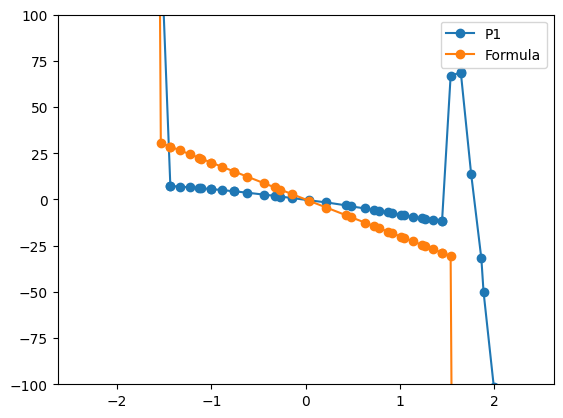

In [142]:
sigma_i_an
plt.plot(ifrd["z"], ifrd["P1"], label="P1",marker="o")
z = ifrd["z"]
zmax = D/2
sigma_i_an = -sigma_max*(E_l[0]/E_eff*(z/zmax) )*(z<-t_n/2) + \
             -sigma_max*(E_n/E_eff   *(z/zmax) )*(z>=-t_n/2)*(z<=t_n/2) + \
             -sigma_max*(E_l[0]/E_eff*(z/zmax) )*(z>t_n/2)

plt.plot(z, sigma_i_an*1e-3, label="Formula",marker="o")
#plt.ylim([-200,850])
plt.legend()
plt.ylim([-100,100])

In [143]:
Eflex_pred

np.float64(15.845752140285697)

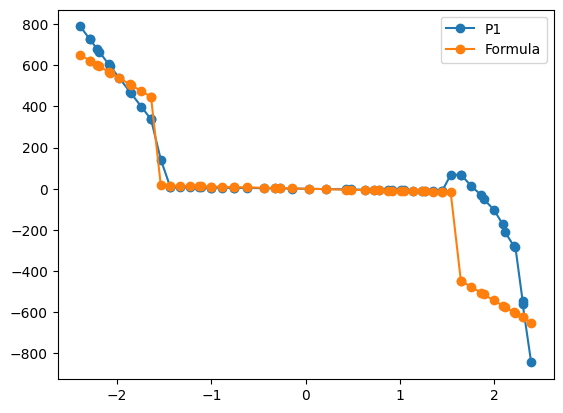

In [144]:

plt.plot(ifrd["z"], ifrd["P1"], label="P1",marker="o")
z = ifrd["z"]
zmax = D/2
sigma_i_an = -sigma_max*((E_l[0]/Eflex_pred)*(z/zmax) )*(z<-t_n/2) + \
             -sigma_max*((E_n   /Eflex_pred)*(z/zmax) )*(z>=-t_n/2)*(z<=t_n/2) + \
             -sigma_max*((E_l[0]/Eflex_pred)*(z/zmax) )*(z>t_n/2)

plt.plot(z, sigma_i_an*1e-3, label="Formula",marker="o")
#plt.ylim([-200,850])
plt.legend()

(-100.0, 100.0)

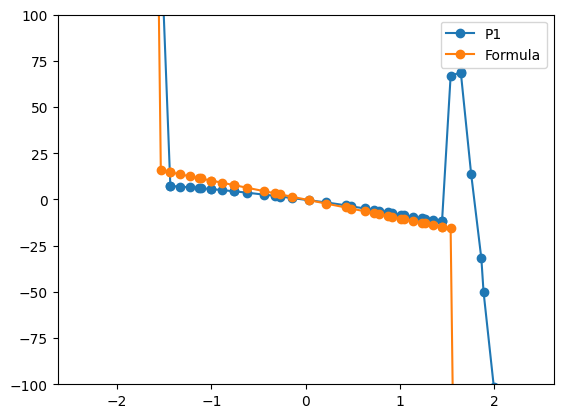

In [151]:

plt.plot(ifrd["z"], ifrd["P1"], label="P1",marker="o")
z = ifrd["z"]
zmax = D/2
sigma_i_an = -sigma_max*((E_l[0]/Eflex_pred)*(z/zmax) )*(z<-t_n/2) + \
             -sigma_max*((E_n   /Eflex_pred)*(z/zmax) )*(z>=-t_n/2)*(z<=t_n/2) + \
             -sigma_max*((E_l[0]/Eflex_pred)*(z/zmax) )*(z>t_n/2)

plt.plot(z, sigma_i_an*1e-3, label="Formula",marker="o")
#plt.ylim([-200,850])
plt.legend()
plt.ylim([-100,100])

In [145]:
D

4.78188

In [146]:
U = params["sim"]["disp"]
E_flexion_formula = P*L**3/(4*U*B*D**3)*1e-3

In [147]:
E_flexion_formula

np.float64(12.136144746821191)

In [148]:
Eflex_pred

np.float64(15.845752140285697)

In [149]:
E_eff

np.float64(8.118669598400627)

In [150]:
E_flexion_formula/(1-0.3**2)

np.float64(13.336422798704605)